In [1]:
#11/07/2019

#Test: Attempt at Text Mining --> PO Tracker

In [2]:
import numpy as np
import pandas as pd

In [3]:
#Read in excel file, sheet 1 with appropiate columns
df = pd.read_excel(r"P:\PO Tracker Todd..xlsx",sheet_name=1,usecols="A:B,D:E,G:K,N:O")
#Get rows below '~' row
index = df.index[df[' Value'] == '~'] #Returns tuple with index of first instance where'Value' column == '~'
df = df.iloc[index[0]+1:]
#Get rid of NaN filled rows
df.dropna(thresh=6,inplace=True)

In [4]:
#Clear any rows with canceled PO's
search = ['Canceled','Closed','No Bid','Denied','Cannot']
data = df[~df['Notes'].str.contains('|'.join(search),case=False)].copy()

In [5]:
#Check column data types
data.dtypes

Notes                                  object
Goods/Service / Change Order/Rental    object
Suppliers                              object
Supplier #                             object
Owner                                  object
Owners Representative                  object
Start Date                             object
End Date                               object
 Value                                 object
REQ                                    object
PO                                     object
dtype: object

In [6]:
#Check for Nan values
data.isnull().any()

Notes                                  False
Goods/Service / Change Order/Rental    False
Suppliers                              False
Supplier #                              True
Owner                                   True
Owners Representative                   True
Start Date                             False
End Date                                True
 Value                                  True
REQ                                    False
PO                                     False
dtype: bool

In [7]:
#Want to see NaN rows in Owner and Owners Rep columns ---> Used Later
data[(data['Owner'].isnull()) | (data['Owners Representative'].isnull()) | (data['Owner'].str.isspace() == True)]

,Notes,Goods/Service / Change Order/Rental,Suppliers,Supplier #,Owner,Owners Representative,Start Date,End Date,Value,REQ,PO
696,Done 8.1.19,Goods,Control Technologies,101050,,Marc Gould,2019-07-31 00:00:00,2019-10-15 00:00:00,46571.5,10003131,4500002384
770,Done 7.11.19,Goods,Carson Valley Golf,101118,NaN,NaN,2019-07-11 00:00:00,2019-07-11 00:00:00,2166.85,10003053,4500002319
1479,Done 2.6.19,Goods,Grainger,100106,Brent Stierwalt,NaN,2019-02-06 00:00:00,2019-02-07 00:00:00,373.58,10002326,4500001714


In [8]:
#Luckily only a few enteries are missing Owner and Owners Represenative values

#Replace value at index 640 with 'Nevada Copper'
#Same with 1349
yeet = data.index[(data['Owner'].isnull()) | (data['Owners Representative'].isnull()) | (data['Owner'].str.isspace() == True)]

data.loc[yeet.tolist()[0],'Owner'] = 'Marc Gould'
data.loc[yeet.tolist()[1],'Owner'] = 'Nevada Copper'
data.loc[yeet.tolist()[1],'Owners Representative'] = 'Nevada Copper'
data.loc[yeet.tolist()[2],'Owners Representative'] = 'Brent Stierwalt'

In [9]:
#Check to see value was changed and saved
data.isnull().any()

Notes                                  False
Goods/Service / Change Order/Rental    False
Suppliers                              False
Supplier #                              True
Owner                                  False
Owners Representative                  False
Start Date                             False
End Date                                True
 Value                                  True
REQ                                    False
PO                                     False
dtype: bool

In [10]:
#Value column has blanks and text(?) --> Covert to numeric, else change to NaN value
#The default return dtype is float64 or int64 depending on the data supplied 
#Use the downcast parameter to obtain other dtypes
data[' Value'] = data[' Value'].apply(pd.to_numeric, errors='coerce')
#Check again for null values
data[' Value'].isnull().any() # There are NaN values
#Find instances of null values
data[data[' Value'].isnull()]
#Replace list
replace = [21727.85,794.51,534.33,8800,0,0,82914.40,641032.57,453.05,18102.50,182519.66,35000,122453.03,119.43]
np_replace = np.array(replace, dtype='float64')
#Replace Nan values with list of retrived PO values
data.loc[data[' Value'].isnull(),' Value'] = np_replace

In [11]:
data[data[' Value'].isnull()]

,Notes,Goods/Service / Change Order/Rental,Suppliers,Supplier #,Owner,Owners Representative,Start Date,End Date,Value,REQ,PO


In [12]:
#Attempt to find any values in 'Start Date' column that are not dates
#Assuming datetime length is 18 characters long
mask = data['Start Date'].apply(lambda x: len(str(x))) < 18
#Get values using boolean mask in 'Start Date' column
#Basically Boolean indexing for values in 'Start Date'
index = data.loc[mask, 'Start Date']
#Turn index to a list and replace those values with ffill values 
data['Start Date'].replace(to_replace=index.tolist(),method='ffill',inplace=True)
data['Start Date'] =  pd.to_datetime(data['Start Date'], infer_datetime_format=True)

#Dates that are mistyped to 1900 instead of 2019
time = pd.Series(['2019/01/02']*4)
timereplace = pd.to_datetime(time,infer_datetime_format=True)

#Create another mask to replace these values (4 in total)
mask2 = data['Start Date'] <= '01/01/2018'
index2 = data.loc[mask2, 'Start Date']

#Turn index2 to a list like before and replace those values with timereplace(?) 
data['Start Date'].replace(to_replace=index2.tolist(),value=timereplace,inplace=True)

#Sort values by 'Start Date' column
data.sort_values(by=['Start Date'],inplace=True)

In [13]:
#TEST

#Get PO's from this year only
cleaned = data[data['Start Date'] >= '01/01/2019'].copy()

#Set index
cleaned.set_index(cleaned['Start Date'],inplace=True,verify_integrity=False)

In [14]:
#Test Continued

import difflib

test = cleaned['Owner'].unique()

#Names used for replacement 
names = ['Lara Sims','Mark Hanley','Samantha Evans','Thomas Bagan']

#Fuzzy MatchUp
closetmatch = [difflib.get_close_matches(options, test,n=len(test),cutoff=.75) for options in names]

dictlist = [dict(zip(closetmatch[i],[names[i]] * len(closetmatch[i]))) for i,_ in enumerate(closetmatch)]

finaldict = {}
for dict1 in dictlist:
    finaldict.update(dict1)

trail = cleaned.copy()

trail['Owner'].replace(to_replace=finaldict,inplace=True)


#Different ways to look at the data
trailgroup = trail.resample('M').agg({"PO":'count'," Value":np.sum})

trail_alternative = pd.pivot_table(trail,index='Owner',
                                    aggfunc={"PO":'count'," Value":np.sum},
                                    values=['PO',' Value'],
                                    margins=True)

#Grouper resamples by month for every 'Owner' for that month
#Aggregate is straightforward
group = trail.groupby([pd.Grouper(freq='M'),'Owner']).agg({"PO":'count'," Value":np.sum})

with pd.ExcelWriter('PO Tracker.xlsx') as writer:
    trailgroup.to_excel(writer, sheet_name = 'Total')
    trail_alternative.to_excel(writer, sheet_name= 'Total by Person for the Year')
    group.to_excel(writer, sheet_name = 'Total by Person by Month')

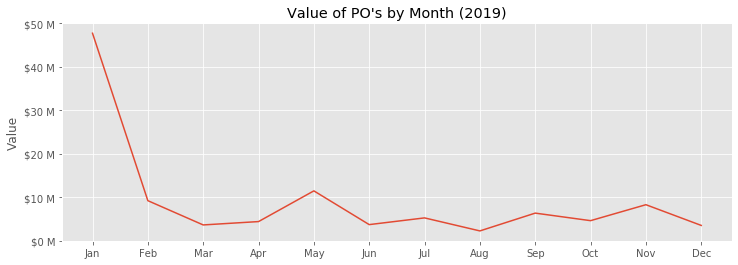

In [16]:
#Quick plot

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

dates = pd.Series(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],dtype=str)

from matplotlib.ticker import LinearLocator, FixedFormatter
y_locator = LinearLocator(6)
y_formatter = FixedFormatter(["$0 M","$10 M","$20 M","$30 M","$40 M","$50 M"])

fig = plt.figure(figsize=(12,4))
ax = plt.axes()
ax.yaxis.set_major_formatter(y_formatter)
ax.yaxis.set_major_locator(y_locator)
ax.plot(dates,trailgroup[' Value'])
ax.set(ylabel='Value',title="Value of PO's by Month (2019)");
